In [1]:
# combining everything we have 
import cv2;
import numpy as np;
from matplotlib import pyplot as plt;
from pywt import dwt2, idwt2;
import pywt;

def find_neighbors(index, dim):
    all_neighbors = []
    x, y = index
    width, height = dim
    
    all_neighbors.append((x, y - 1))
    all_neighbors.append((x, y + 1))
    all_neighbors.append((x - 1, y))
    all_neighbors.append((x + 1, y))
    all_neighbors.append((x - 1, y - 1))
    all_neighbors.append((x + 1, y - 1))
    all_neighbors.append((x - 1, y + 1))
    all_neighbors.append((x + 1, y + 1))

    neighbors = [index]
    #     save the location that the pixel is on for comparison
    for i in all_neighbors:
        if (i[0] >= width) or (i[1] >= height):
            continue
        elif (i[0] >= 0) and (i[1] >= 0):
            neighbors.append(i)
    return neighbors

# generates the prewitt kernels which will give us the approximate second derivative of gaussian 
def kernelGen(dim, isX):
    if(isX):
        kernelx = np.ones((1,dim), dtype = int) * -1
        zeros = np.zeros((1,dim), dtype = int)
        ones = np.ones((1,dim), dtype = int)
        for num in range(0,dim-2):
            kernelx = np.concatenate((kernelx, zeros), axis = -1)
        kernelx = np.concatenate((kernelx, ones), axis = -1)
        kernelx = np.resize(kernelx, (dim,dim))
        return kernelx
    else:
        kernely =  np.ones((dim,1), dtype = int) * -1
        zeros = np.zeros((dim,1), dtype = int)
        ones = np.ones((dim,1), dtype = int)
        for num in range(0,dim-2):
            kernely = np.concatenate((kernely, zeros), axis = -1)
        kernely = np.concatenate((kernely, ones), axis = -1)
        kernely = np.resize(kernely, (dim,dim))
        return kernely
    
def SURF(image):
    img = image
    # convert image to grayscale 
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    fSize = [9, 15, 21, 27]
    
    ndet = [] # list of numpy arrays of dim 300*300
    for size in fSize:
        kernelx = kernelGen(size, True)
        kernely = kernelGen(size, False)

        Dx = cv2.filter2D(gray, -1, kernelx)
        Dxx = cv2.filter2D(Dx, -1, kernelx)
        Dy = cv2.filter2D(gray, -1, kernely)
        Dyy = cv2.filter2D(Dy, -1, kernely)
        Dxy = cv2.filter2D(Dx, -1, kernely)
        
        # no resizing necessary since this is already a square matrix originally when we run it
        # resize in order to evaluate determinant
#         new_Dyy = cv2.resize(Dyy, (Dyy.shape[0],Dyy.shape[1])) #flip row & col
#         new_Dxy = cv2.resize(Dxy, (Dxx.shape[0],Dyy.shape[1])) 
        
        # evaluate determinant based equation given from paper
        determinant = np.dot(Dxx,Dyy)-(np.square(.9)*np.dot(Dxy, Dxy)) 
        ndet.append(determinant)
    
    det = [] # list of determinant list 
    for i in range(0, len(ndet)):
        det.append(ndet[i].tolist())
    
    kp = [] # stores key points
    loc = [] # stores location of key point
    # now for the non-maximum suppression in 3*3*3 neighborhood between scales
    for index in range(0, len(det)):
        if(index == 0 or index == len(det) - 1):
            continue
        instance = det[index] # 300 * 300 square matrix
        width = len(instance[1])
        height = len(instance[0])
        instance_dim = (width, height)
        for row in range(width):
            for col in range(height):
                neighbors_to_check = []
                current = instance[row][col] 
                upper = det[index+1]
                lower = det[index-1]
                neighbors = find_neighbors((row, col), instance_dim)
                # retrieves all valid neighbors to check, upper & lower neighbor check positions will be exactly the same
                for position in neighbors:
                    neighbors_to_check.append(upper[position[0]][position[1]])
                    neighbors_to_check.append(lower[position[0]][position[1]])
                    neighbors_to_check.append(instance[position[0]][position[1]])
                # node in same position in upper and lower level also needs to be compared
                neighbors_to_check.append(upper[row][col])
                neighbors_to_check.append(lower[row][col])
                if not (current == max(neighbors_to_check) and current > 200):
                    continue
                else:
                    kp.append(current)
                    loc.append((row,col))
#         print('Length of keypoint locations found', len(loc))
#         print('Length of location set', len(set(loc)))
#         print('Location keypoints:', loc)
        return loc

original = cv2.imread('red_panda.jpg') # converted to grayscale within SURF function
resize = cv2.resize(original, (200,200)) # standardize image size
original_result = SURF(resize)
print('Number of keypoints found:')
print(len(original_result))

# stores quadrant keypoints from original, need to check tuple values
q1_r = []
q2_r = []
q3_r = []
q4_r = []
total = 200 # total allowed size
sep = 100 # quadrant separation vals
for point in original_result:
    # results in q1
    if (point[0] >= sep and point[0] < total) and (point[1] >= 0 and point[1] < sep):
        q1_r.append(point)
    elif (point[0] >= 0 and point[0] < sep) and (point[1] >= 0 and point[1] < sep):
        q2_r.append(point)
    elif (point[0] >= 0 and point[0] < sep) and (point[1] >= sep and point[1] < total):
        q3_r.append(point)
    elif (point[0] >= sep and point[0] < total) and (point[1] >= sep and point[1] < total):
        q4_r.append(point)
    else:
        print("Fix the positions")
print(q1_r[0], len(q1_r))

Number of keypoints found:
751
(100, 54) 188


In [2]:
# SURF on quadrants
width = resize.shape[1] # 200
height = resize.shape[0] # 200
w = int(width/2) 
h = int(height/2) 
q1 = resize[0:h, w:width]
q1_result = SURF(q1)
print(len(q1_result))
q2 = resize[0:h, 0:w]
q2_result = SURF(q2)
print(len(q2_result))
q3 = resize[h:height, 0:w]
q3_result = SURF(q3)
print(len(q3_result))
q4 = resize[h:height, w:width]
q4_result =  SURF(q4)
print(len(q4_result))

186
164
152
240


### Euclidean distance
(x',y') will be our target keypoint from the whole image
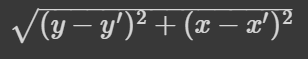

In [3]:
import math

# compares the section result to the entire result
def compare_result(section, whole):
    min_distance = 0
    for i in whole:
        temp = math.sqrt(((section[1] - i[1])**2) + ((section[0] - i[0])**2))
        if (min_distance == 0) or (min_distance > temp):
            min_distance = temp
    return min_distance

def findDistance(array):
    total = 0
    for point in array:
        total += compare_result(point, original_result)
    avg = total/len(array)
#     print('Average euclidean distance', avg)
    return round(avg, 4)

def findNumMatches(quad, whole):
    num = 0
    for i in range(len(quad)):
        if(quad[i] in whole):
            num += 1
#     print(num)
    return num

def getPercentage(n, poss):
    return round((n/poss)*100, 2)

# checking method functionality
# l1 = [(1,1),(2,3)]
# l2 = [(6,6),(1,1)]
# print('match', findNumMatches(l1, l2))
# print('percent', getPercentage(findNumMatches(l1, l2),len(l2)))
      
print('\nEuclidean Distance:')
# find average distances of each quadrant
c1 = q1_result
c2 = q1_result + q2_result # q1 + q1
c3 = c2 + q3_result # q1 + q2 + q3
c4 = c3 + q4_result # all quadrants
print('uncleaned distance:')
print(findDistance(c1))
print(findDistance(c2))
print(findDistance(c3))
print(findDistance(c4))
print('cleaned distance:')
print(findDistance(list(set(c1))))
print(findDistance(list(set(c2))))
print(findDistance(list(set(c3))))
print(findDistance(list(set(c4))))

t1 = q1_r
t2 = q1_r + q2_r
t3 = t2 + q3_r
t4 = t3 + q4_r

print('\nPerfect Keypoint Matches')
# print('Uncleaned % results:')
print('hit:')
print(findNumMatches(c1, t1)) 
print(findNumMatches(c2, t2))
print(findNumMatches(c3, t3))
print(findNumMatches(c4, t4))
    
print('out of:')
print(len(t1)) 
print(len(t2))
print(len(t3))
print(len(t4))
    
print('percentages: ')
print(getPercentage(findNumMatches(c1, t1), len(t1)), '%')
print(getPercentage(findNumMatches(c2, t2), len(t2)), '%')
print(getPercentage(findNumMatches(c3, t3), len(t3)), '%')
print(getPercentage(findNumMatches(c4, t4), len(t4)), '%')


Euclidean Distance:
uncleaned distance:
3.6164
3.7398
3.6849
3.6339
cleaned distance:
3.6164
3.742
3.6927
3.6261

Perfect Keypoint Matches
hit:
0
9
13
19
out of:
188
380
582
751
percentages: 
0.0 %
2.37 %
2.23 %
2.53 %


In [ ]:
# print(len(q1_r))
# print(len(q2_r))    
# print(len(q3_r))    
# print(len(q4_r))    